# Data Masters Case: Exploração inicial

Felipe Viacava -- São Paulo, ago/2023

O presente documento consiste na análise exploratória inicial dos dados fornecidos para a solução do Case "Data Masters - Cientista de Dados" do Santander Brasil. O objetivo é conhecer melhor os dados para definir com assertividade cada passo do processo de modelagem para as duas primeiras partes do projeto, que envolvem a classificação de clientes como satisfeitos ou insatisfeitos.

As premissas do presente documento são as seguintes:
- Os dados fornecidos são confiáveis e representam a realidade;
- Os dados fornecidos são suficientes para a solução do problema;
- O problema é bem definido e pode ser resolvido com técnicas de classificação;
- A análise exploratória deve contemplar apenas um subconjunto dos dados para evitar _data leakage_, garantindo que a etapa de testes seja a mais próxima possível de um modelo em produção, sem qualquer viés decorrente dessa etapa;
- Nenhuma transformação realizada nesta etapa deve ser gravada em disco. Aqui, os passos de transformação serão definidos para aplicação nos _pipelines_ de classificação, garantindo maior reprodutibilidade e facilidade de manutenção;
- Dada a quantidade de variáveis, seus prefixos e a ausência de metadados que descrevam suas características e seus propósitos de negócio, assumiu-se o contexto da empresa Santander Brasil enquanto banco para realizar suposições sobre as variáveis. Cada grupo de variáveis tem sua própria seção neste documento com suas premissas e análises. 

## Bibliotecas

In [1]:
# --- Data Exploration --- #
import pandas as pd
import missingno as mno
import matplotlib.pyplot as plt
import resources.customviz as cv
import seaborn as sns
from resources.edautils import neg_pos_zero

# --- Data Processing --- #
import numpy as np
from sklearn.model_selection import train_test_split
from resources.customtransformers import \
    DropConstantColumns, \
    DropDuplicateColumns, \
    AddNonZeroCount, \
    CustomSum, \
    CustomImputer, \
    AddNoneCount

# --- Setting Global Options --- #
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Separação em treino e teste

Como explicitado nas premissas deste documento, o conjunto de dados foi dividido entre treino e teste para evitar _data leakage_. A utilizamos 80% do conjunto original, estratificado pela variável de interesse ("TARGET").

In [2]:
df = pd.read_csv("data/raw.csv")

df, test = train_test_split(df, stratify=df["TARGET"], random_state=42, train_size=.8)

df.to_csv("data/train.csv")
test.to_csv("data/test.csv")

del test

df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

## Análise Exploratória e Feature Engineering

A análise exploratória segue as premissas descritas no cabeçalho deste documento, e foi dividida em 3 partes:
- Análise generalizada, onde se detectou a presença de colunas constantes e/ou duplicadas;
- Análise por prefixo, onde se assumiram as mesmas premissas para variáveis com o mesmo prefixo;
- Análise individual para variáveis sem prefixos.

Cada parte inclui apenas as colunas que não foram descartadas nas etapas anteriores, ou seja: uma variável de prefixo "ind" que tenha sido encontrada como constante ou duplicada na primeira etapa de análise (e processamento, durante a transformação no _pipeline_) não foi analisada durante a seção de seu prefixo.

Muitas variáveis compartilham o nome principal ("var30", por exemplo), indicando que uma variável de prefixo "ind" por ser um indicador de uma variável de prefixo "saldo". Contudo, por haver muitos nomes, esta relação foi deixada como um ponto a melhorar em futuras versões deste _case_.

### Removendo variáveis constantes e duplicadas

Percebeu-se a existência de variáveis constantes e/ou duplicadas.

Variáveis aleatórias constantes não servem propósito algum na modelagem e ocupam espaço na memória, aumentando o custo computacional sem qualquer benefício na predição. Isso motiva a criação de um transformador customizado que detecta estas variáveis durante o _fit_ (considerando apenas o subconjunto de treino) e as remove durante a transformação (tanto no subconjunto de treino quanto no de teste).

Variáveis duplicadas, por outro lado, aumentam a probabilidade de uma variável ser selecionada nos _splits_ de uma floresta aleatória, por exemplo. Dada a esparsidade dos dados fornecidos, isso poderia ser uma técnica para atribuir um peso maior a uma variável, mas por falta de conhecimento ou experiência com este tipo de decisão, optou-se por remover a duplicidade. Ao remover duplicatas, a variável escolhida para continuar no conjunto é a primeira por ordem alfabética.

Os dois transformadores utilizados para realizar esta operação são DropConstantColumns e DropDuplicateColumns, encontrados no arquivo "customtransformers.py", na pasta "resources" deste projeto.

In [3]:
dcc = DropConstantColumns(print_cols=True)
dcc = dcc.fit(df)
df = dcc.transform(df)

47 constant columns were found


In [4]:
ddc = DropDuplicateColumns(print_cols=True)
ddc = ddc.fit(df)
df = ddc.transform(df)

25 duplicate columns were found.


### Valores faltantes

Percebeu-se que não há nenhum valor faltante no conjunto de dados. Isso indica que, possivelmente, estes dados passaram por algum tratamento prévio, onde os valores faltantes foram preenchidos ou removidos. A investigação sobre dados faltantes, nesta análise, é própria de cada prefixo ou variável sem prefixo.

In [5]:
print("Número de valores faltantes no dataset:", df.isna().sum().sum())

Número de valores faltantes no dataset: 0


### ID

Assumiu-se que esta coluna é o ID anonimizado de cada observação (cliente) da base, tanto pelo nome quanto por não conter nenhum valor duplicado ou faltante. Esta coluna não deve ser usada em hipótese alguma durante o treinamento, pois por ser uma chave única, não há como generalizar o aprendizado para novos clientes (_overfitting_).

In [6]:
df["ID"].nunique() / df.shape[0]

1.0

### TARGET

Assumiu-se que esta é a variável de interesse do problema por conta de seu nome e por ser binária (considerando que este é um problema de classificação binária).

In [7]:
df["TARGET"].value_counts(normalize=True).reset_index().set_index("TARGET")

,proportion
TARGET,
0,0.960438
1,0.039562


### Saldo

Assumiu-se, partindo das premissas descritas no cabeçalho, que esta é uma variável numérica, pois o prefixo "saldo" sugere que se trata de uma valor monetário. Como são muitas colunas, entende-se que se trata do saldo que um cliente tem em diversos produtos financeiros.

Números decimais, números negativos (no caso de um produto como Cheque Especial) e muitos valores únicos corroboram esta hipótese, assim como a esparsidade destes dados: com algum conhecimento de negócios, podemos inferir que é incomum um cliente possuir saldo em todos os produtos financeiros que o banco oferece.

Para detectar clientes com muitos produtos, foi criado o transformador "_AddNonZeroCount_", que conta a quantidade de valores diferentes de zero um cliente tem nas colunas mesmo prefixo. Essa variável mostra que clientes com mais produtos tendem a ser mais satisfeitos -- o que faz sentido, pois mostra que com maior satisfação, o cliente tende a adquirir mais produtos.

Para encontrar a diferença entre os saldos dos clientes de modo geral, foi criado o transformador "_CustomSum_", que soma os valores de todas as colunas com o mesmo prefixo. Diferentemente da contagem de não-zeros, essa variável não aparenta ter poder de discriminação relevante

#### Verificações generalizadas

In [8]:
saldo_cols = [
    col
    for col in df.columns
    if col.startswith("saldo")
]

df[saldo_cols].describe()

,saldo_var1,saldo_var5,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3
count,6.081600e+04,60816.000000,60816.000000,6.081600e+04,60816.000000,6.081600e+04,6.081600e+04,60816.000000,6.081600e+04,6.081600e+04,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,6.081600e+04,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,6.081600e+04,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000
mean,5.421243e+01,1023.580114,147.164810,6.145564e+03,5007.146940,1.556449e+03,6.563596e+03,73.400380,2.193110e+02,4.932912e+01,29.460104,6.042704e+03,77.008466,73.592049,0.518094,1.388042e+04,3.350655e+02,3.416418,8.024900,0.838595,37.824253,4.044708,7.316827e+03,107.729578,1574.486122,8.892026e+02,1084.740443,1056.020634,72.059624,9.595272,129.412427,113.547998,4.096795e+03,632.316635,5.827253e+03,4.479855e+03,3632.299539,563.873755,4867.817947,3869.127405,801.746822,165.940223,9.967677e+02,7.797536e+02,1.076352e+02,4.474321e+01,1.559413e+02,1.300591e+02,0.266339,0.002388,0.317384,0.233287,6.440666,1.311271,7.954414,5.865130,33.599873,1.668842,82.080819,61.958431
std,1.216651e+04,9631.082614,2638.277572,4.976986e+04,32708.177345,2.077014e+04,3.888554e+04,3051.818963,2.535943e+04,1.216501e+04,2748.430264,4.961221e+04,769.211470,755.560611,92.904907,6.467857e+04,2.601808e+04,131.023675,492.024186,158.144155,500.605840,109.663575,5.069721e+04,5733.602855,11921.458336,1.031913e+04,9390.625089,8065.251410,1870.405196,481.561337,2268.032588,1945.458121,3.961191e+04,9593.663815,4.789661e+04,3.649015e+04,26286.326792,7297.654879,31963.155279,25587.988788,13401.769748,4705.909949,1.661751e+04,1.279101e+04,1.719559e+04,9.627698e+03,1.670705e+04,1.461361e+04,46.756603,0.588786,58.225764,35.642179,416.720118,116.443347,488.355798,353.187991,2193.005808,140.817701,4381.968936,3106.016476
min,0.000000e+00,-1842.000000,-4942.260000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-4.942260e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-4.942260e+03,0.000000,-128.370000,-8.040000e+00,-922.380000,-476.070000,-287.670000,0.000000,-3401.340000,-1844.520000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-3.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [9]:
df[saldo_cols] \
    .nunique() \
    .nlargest(5) \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    ) \
    .set_index("Column")

,Number of unique values
Column,
saldo_medio_var5_ult3,14582
saldo_var30,13974
saldo_var42,12946
saldo_medio_var5_ult1,12279
saldo_medio_var5_hace2,12115


In [10]:
neg_pos_zero(df, saldo_cols) # Esta função foi criada no arquivo "edautils.py"

,Column,Negative values (%),Positive values (%),Zero values (%)
0,saldo_var1,0.000000,0.358458,99.641542
33,saldo_medio_var12_hace3,0.000000,1.687056,98.312944
34,saldo_medio_var12_ult1,0.000000,4.589253,95.410747
35,saldo_medio_var12_ult3,0.000000,4.589253,95.410747
36,saldo_medio_var13_corto_hace2,0.000000,3.897001,96.102999
37,saldo_medio_var13_corto_hace3,0.000000,1.784070,98.215930
38,saldo_medio_var13_corto_ult1,0.000000,4.181465,95.818535
39,saldo_medio_var13_corto_ult3,0.000000,4.181465,95.818535
40,saldo_medio_var13_largo_hace2,0.000000,0.656077,99.343923
41,saldo_medio_var13_largo_hace3,0.000000,0.406143,99.593857


#### Feature engineering

##### Contagem de colunas diferentes de 0

In [11]:
anzc_saldo = AddNonZeroCount(prefix="saldo")
anzc_saldo = anzc_saldo.fit(df)
df = anzc_saldo.transform(df)

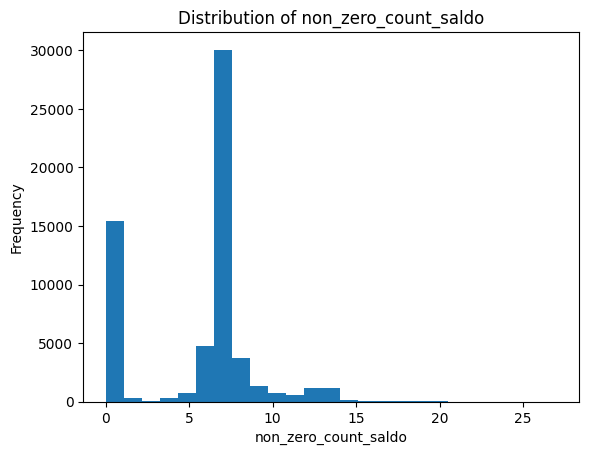

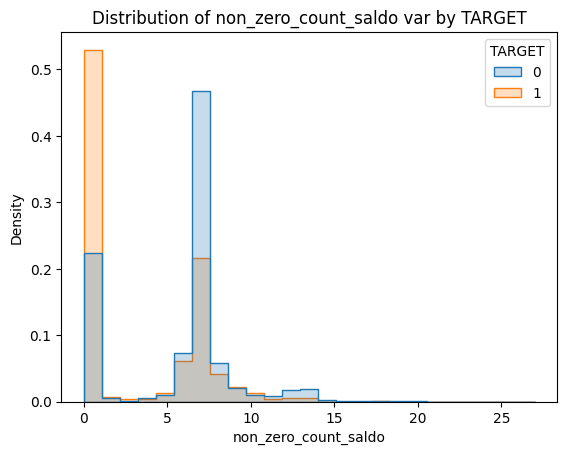

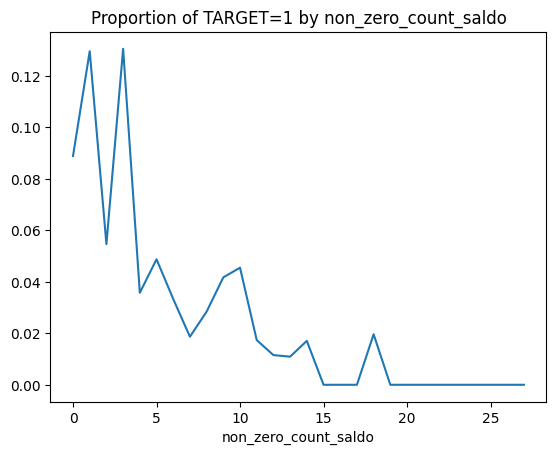

In [12]:
cv.histplot(df, "non_zero_count_saldo", nbins=25)
cv.binaryhistplot(df, "non_zero_count_saldo", nbins=25)
cv.lineplot(df, "non_zero_count_saldo")

##### Soma total das colunas

In [13]:
cs_saldo = CustomSum(prefix="saldo")
cs_saldo = cs_saldo.fit(df)
df = cs_saldo.transform(df)

df_ = df.copy()
min_sum = df_["sum_of_saldo"].min()

df_["sum_of_saldo"] = df_["sum_of_saldo"] \
    .apply(
        lambda x:
            np.log(
                x - min_sum + 1
            )
        )

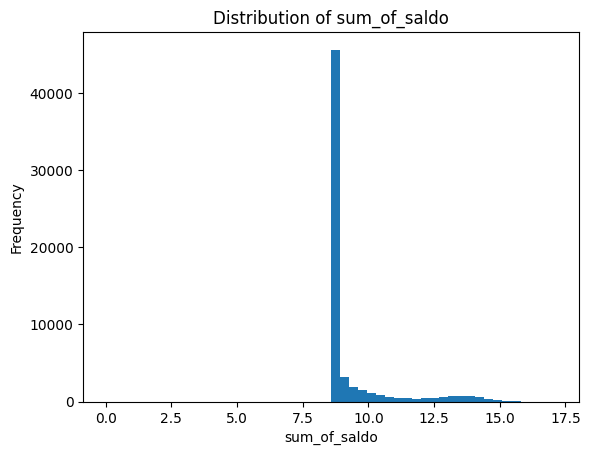

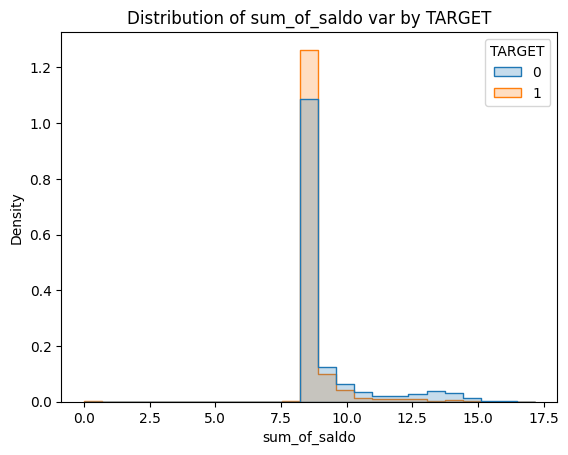

In [14]:
cv.histplot(df_, "sum_of_saldo", nbins=50)
cv.binaryhistplot(df_, "sum_of_saldo", nbins=25)

### Imp

Assumindo que "imp" se deriva de "imposición", ou seja, algum tipo de taxa, com caracteríticas semelhantes às descritas no subset de "saldo"(com excessão de valores negativos, que aqui não existem), também partimos do pressuposto de que estas são variáveis numéricas. Foram criadas as mesmas colunas que no subset de "saldo", com exceção da coluna de saldo médio por produto.

Aqui o resultado foi contrário ao observado em "saldo": os clientes com maior quantidade de taxas são mais insatisfeitos. No caso de "saldo", contudo, a proporção de clientes insatisfeitos é maior onde o número de amostras é maior. Aqui, o efeito é contrário, ou seja, a discriminação criada pela variável de contagem atua sobre um número pequeno de observações.

A soma total parece não ter efeito sobre sobre a satisfação.

#### Verificações generalizadas

In [15]:
imp_cols = [
    col
    for col in df.columns
    if col.startswith("imp")
]

df[imp_cols].describe()

,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1
count,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.00000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04
mean,81.239989,72.185307,119.169036,3.164183,5.748708,0.406672,0.566005,2.919893,69.021124,113.420328,67.706449,111.796809,137.324003,68.113121,112.362815,140.243896,4.13353,0.258021,0.022564,2848.155970,631.587649,1.197763e+02,34.288115,2.484215,0.034530,3.401817,1.480680e+02,11.881684,1.416635e+02,48.352820,0.197763,14.439225,870.980582,1.934909e+03,2.343510,3.140848,2.339529,3.067888,0.173346,0.049329,1.283605,9.881891e+01
std,1364.095864,338.049064,544.262724,86.245545,142.173207,32.490295,38.812040,92.048327,320.203951,514.898002,526.841213,849.182252,700.709527,530.960400,853.740784,715.611960,286.69313,63.630281,4.583333,25562.833133,11407.934951,2.472546e+04,2666.701966,207.221753,4.213975,619.668860,7.036092e+03,936.771518,1.522183e+04,3014.222511,48.770117,1206.329762,13961.760981,2.340013e+04,434.070579,569.043654,399.381114,346.953267,26.398397,12.165006,316.454762,1.260544e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
max,135000

In [16]:
df[imp_cols] \
    .nunique() \
    .sort_values() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,imp_amort_var18_ult1,2
1,imp_trasp_var33_out_ult1,2
2,imp_reemb_var17_hace3,2
3,imp_venta_var44_hace3,3
4,imp_amort_var34_ult1,3
5,imp_trasp_var17_in_hace3,3
6,imp_trasp_var17_out_ult1,4
7,imp_trasp_var33_in_ult1,4
8,imp_var7_emit_ult1,4
9,imp_trasp_var17_in_ult1,5


#### Feature Engineering de "imp"

##### Contagem de colunas diferentes de 0

In [17]:
anzc_imp = AddNonZeroCount(prefix="imp")
anzc_imp = anzc_imp.fit(df)
df = anzc_imp.transform(df)

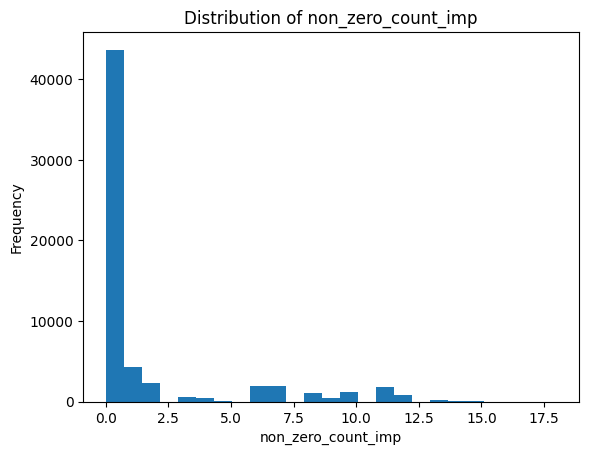

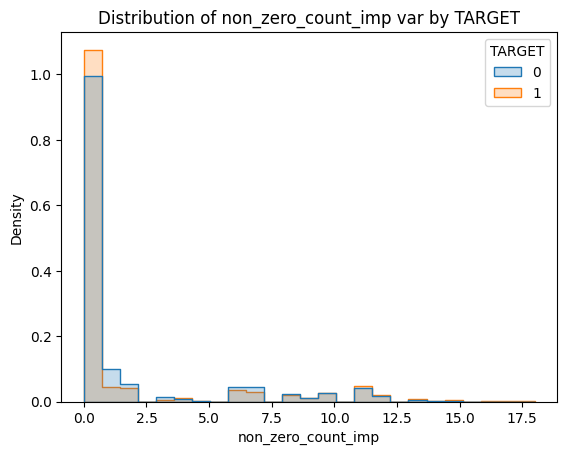

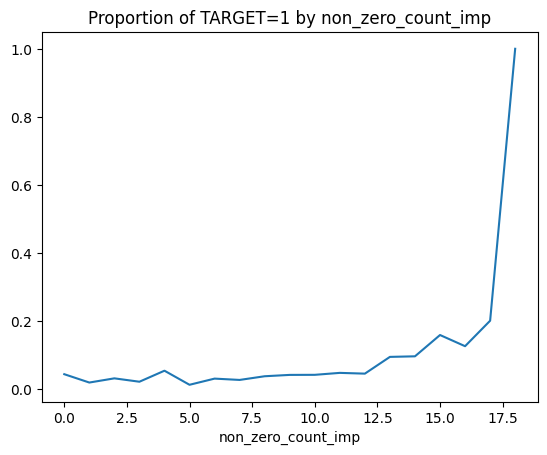

In [18]:
cv.histplot(df, "non_zero_count_imp", nbins=25)
cv.binaryhistplot(df, "non_zero_count_imp", nbins=25)
cv.lineplot(df, "non_zero_count_imp")

##### Soma total das colunas

In [19]:
cs_imp = CustomSum(prefix="imp")
cs_imp = cs_imp.fit(df)
df = cs_imp.transform(df)

df_ = df.copy()
min_sum = df_["sum_of_imp"].min()

df_["sum_of_imp"] = df_["sum_of_imp"] \
    .apply(
        lambda x:
            np.log(
                x + 1
            )
        )

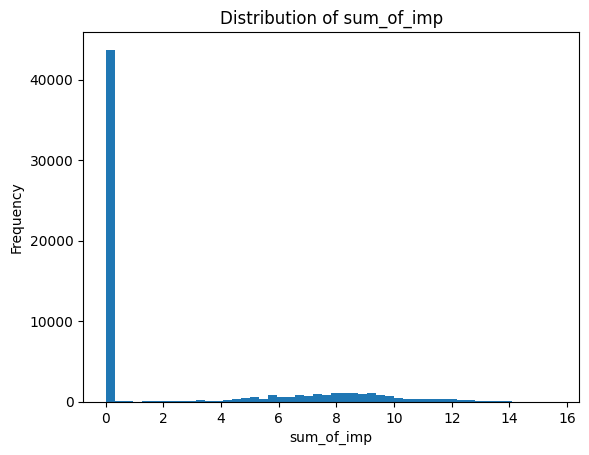

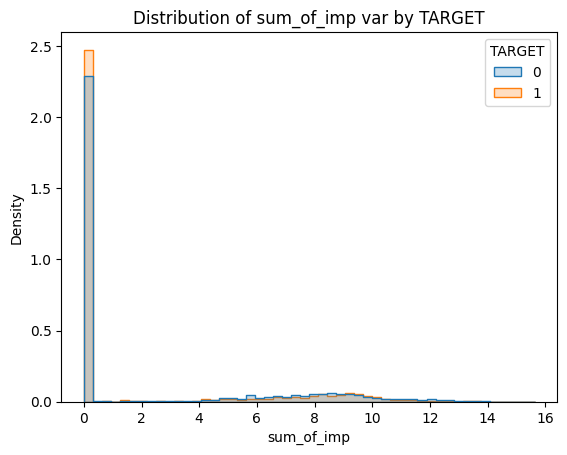

In [20]:
cv.histplot(df_, "sum_of_imp", nbins=50)
cv.binaryhistplot(df_, "sum_of_imp", nbins=50)

### Delta

O nome da coluna sugere que seja algum tipo de variação. Assim, também assumimos que se trata de uma variável numérica. Mesmo que haja poucos valores únicos, aqueles que são diferentes de zero são, em geral, negativos ou decimais.

Diferentemente dos demais subconjuntos estudados até o momento, acredita-se haver valores nulos neste subconjunto, mas que foram preenchidos com 9999999999. Todas as colunas deste subconjunto compartilham este valor como valor máximo, sendo que ao removê-lo o maior valor máximo é de 8.

Estes valores nulos não serão tratados para o problema de classificação, pois as implementações de modelos baseados em árvores do sklearn, assim como o XGBoost e o LightGBM têm uma estratégia implícita para lidar com valores faltantes. Em cada nó, os algoritmos encontram o _split_ que minimiza a função de custo desconsiderando valores faltantes. Encontrado este split, os modelos testam em qual dos nós filhos as observações com valores faltantes devem ser alocadas: o nó filho que minimizar a função de custo é o escolhido para alocá-las. Estes modelos também testam se o melhor _split_ é, na verdade, separar faltantes de preenchidos, eliminando também a necessidade de criar uma _flag_ para nulo em determinada coluna.

Assim, o primeiro passo foi criar a classe "CustomImputer", que substitui estes valores falsos inseridos por nulos. Neste caso, seria possível fazer o mesmo processo com uma função, mas optou-se por usar uma classe para manter a consistência com o restante do projeto. Outro caminho seria usar un FunctionTransformer com uma função de substituição dentro de um ColumnTransformer para aplicar a substituição apenas nas colunas desejadas. A seleção das colunas por prefixo precisaria ser feita com auxílio de outra ferramenta do sklearn, que permite selecionar as colunas do ColumnTransformer usando RegEx.

Ao substituir valores falsos por valores nulos, percebeu-se que colunas se tornaram constantes (havendo apenas 0s e nulos), mas estas não foram removidas devido à propriedade das implementações de árvores de decisão descritas anteriormente. Percebe-se também que há correlação entre observações na presença de valores nulos em mais de uma coluna, mas apenas entre variáveis com nomes semelhantes -- corroborando a ideia de que muitas das variáveis estão diretamente relacionadas umas com as outras.

Em seguida, foi criado um transformador para contar valores nulos neste subconjunto, mas a variável criada não aparenta ter poder de discriminação, assim como a contagem de não-zeros e a soma total.

#### Verificações generalizadas de "delta"

In [21]:
delta_cols = [
    col
    for col in df.columns
    if col.startswith("delta")
]

df[delta_cols].describe()

,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3
count,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04
mean,1.644304e+05,3.288608e+05,4.817811e+07,5.590634e+06,1.644304e+05,9.701394e+06,5.097343e+06,2.466456e+06,6.577217e+05,4.932912e+05,4.932912e+05,1.644304e+05,6.248356e+06,4.817811e+07,5.590634e+06,1.644304e+05,9.701394e+06,6.248356e+06
std,4.055002e+07,5.734592e+07,6.924362e+08,2.363811e+08,4.055002e+07,3.113221e+08,2.257173e+08,1.570315e+08,8.109804e+07,7.023354e+07,7.023354e+07,4.055002e+07,2.498911e+08,6.924362e+08,2.363811e+08,4.055002e+07,3.113221e+08,2.498911e+08
min,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10


In [22]:
df[delta_cols] \
    .nunique() \
    .sort_values() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,delta_imp_amort_var18_1y3,2
1,delta_imp_amort_var34_1y3,2
2,delta_imp_trasp_var33_out_1y3,2
3,delta_imp_trasp_var17_out_1y3,2
4,delta_imp_reemb_var13_1y3,2
5,delta_num_aport_var17_1y3,3
6,delta_imp_trasp_var33_in_1y3,3
7,delta_imp_trasp_var17_in_1y3,3
8,delta_imp_reemb_var17_1y3,3
9,delta_imp_aport_var17_1y3,4


In [23]:
ci_delta = CustomImputer(prefix="delta", to_replace=9999999999)
ci_delta = ci_delta.fit(df)
df = ci_delta.transform(df)

In [24]:
print("Colunas constantes após substituição:", sum(df.nunique()==1))

Colunas constantes após substituição: 5


In [25]:
df[delta_cols].describe()

,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3
count,60815.0,60814.0,60523.000000,60782.000000,60815.000000,60757.000000,60785.0,60801.000000,60812.000000,60813.0,60813.000000,60815.0,60778.000000,60523.000000,60782.000000,60815.000000,60757.00000,60778.000000
mean,0.0,0.0,-0.021865,-0.000206,-0.000265,-0.000008,0.0,-0.000016,-0.000033,0.0,-0.000082,0.0,0.000073,-0.022091,-0.000230,-0.000222,0.00003,0.000115
std,0.0,0.0,0.151406,0.016350,0.015977,0.035928,0.0,0.004056,0.005735,0.0,0.009067,0.0,0.022345,0.147205,0.015175,0.014759,0.02945,0.032703
min,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.000000,0.0,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,0.0,0.0,5.500000,1.500000,0.000000,6.267608,0.0,0.000000,0.000000,0.0,0.000000,0.0,5.417098,1.000000,0.000000,0.000000,4.00000,8.000000


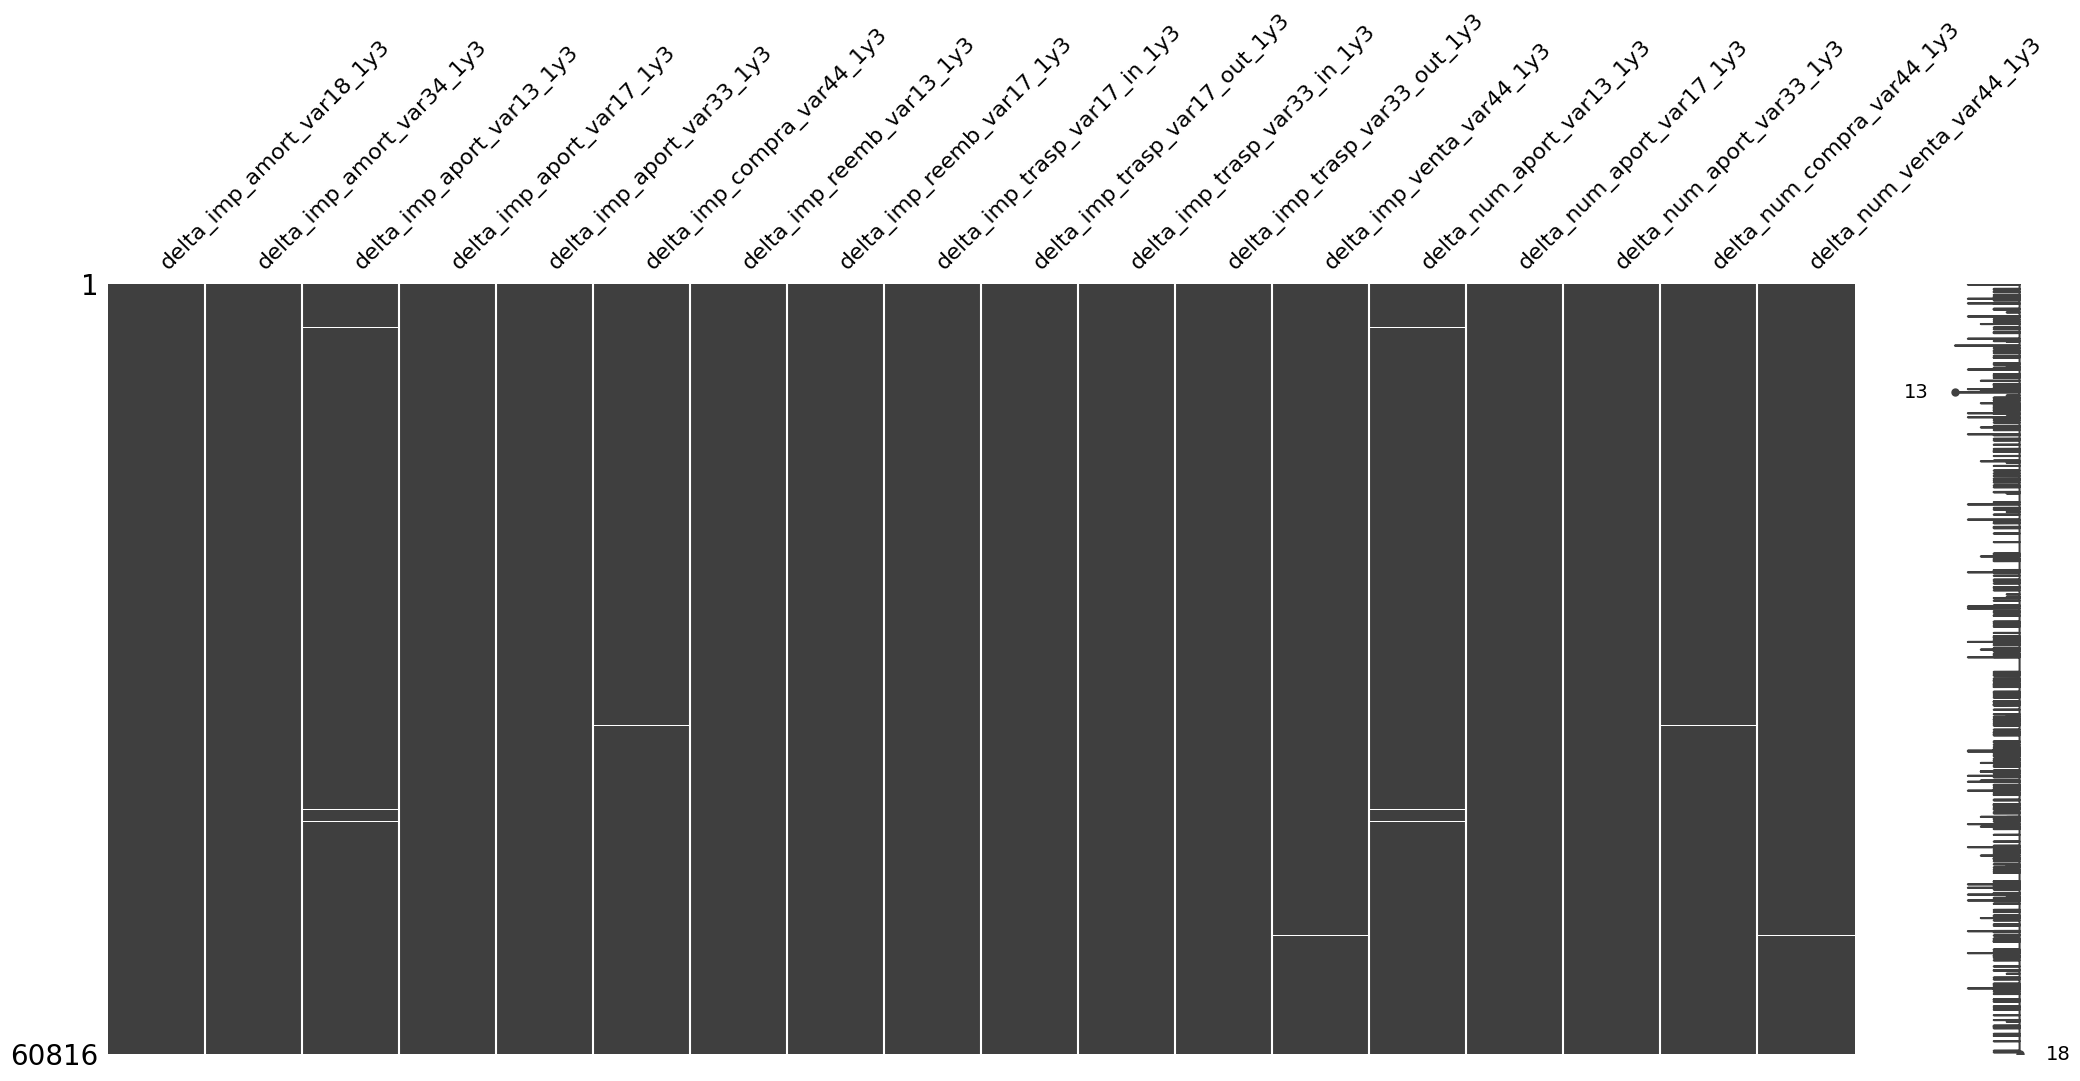

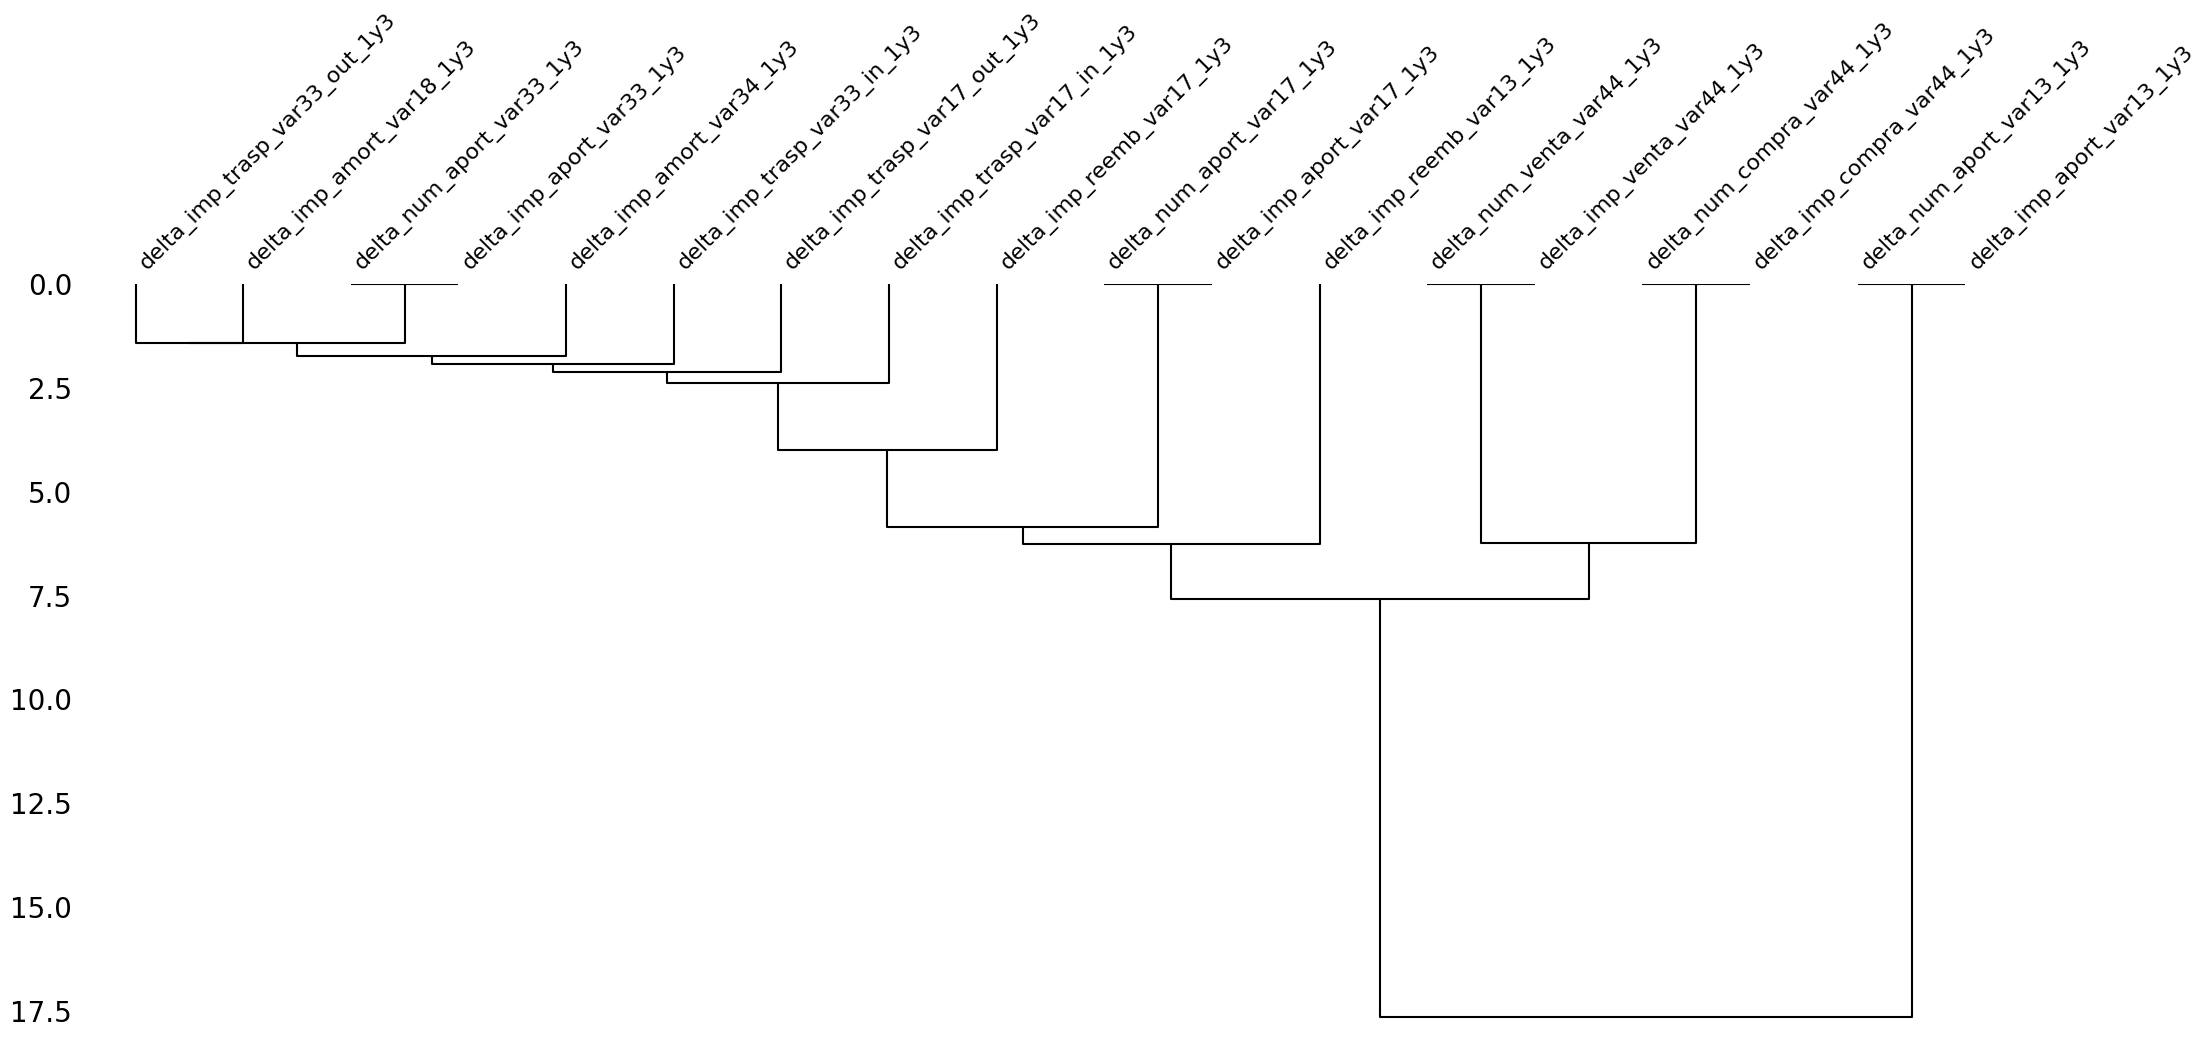

In [26]:
mno.matrix(df[delta_cols])
plt.show()
mno.dendrogram(df[delta_cols])
plt.show()

#### Feature Engineering de "delta"

##### Contagem de nulos

In [27]:
anc_delta = AddNoneCount(prefix="delta")
anc_delta = anc_delta.fit(df)
df = anc_delta.transform(df)

In [28]:
df["none_count_delta"].value_counts()

none_count_delta
0    60387
2      348
1       32
4       31
3       16
5        2
Name: count, dtype: int64

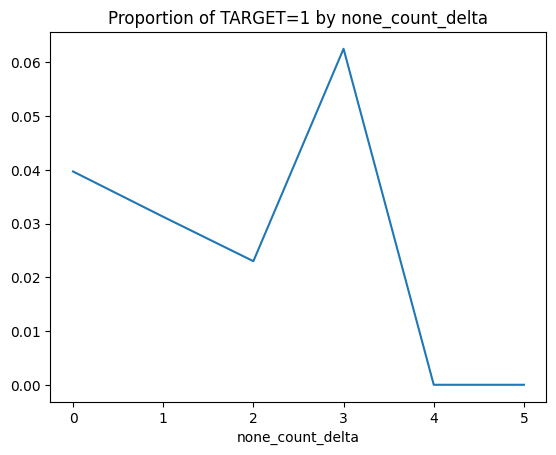

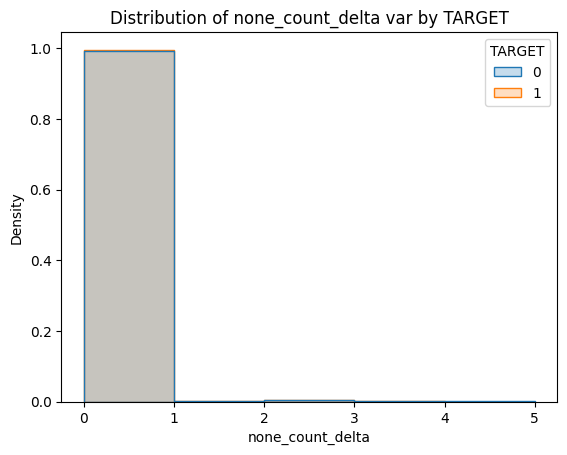

In [29]:
cv.lineplot(df, "none_count_delta")
cv.binaryhistplot(df, "none_count_delta",nbins=5)

##### Contagem de colunas diferentes de 0

In [30]:
anzc_delta = AddNonZeroCount(prefix="delta")
anzc_delta = anzc_delta.fit(df)
df = anzc_delta.transform(df)

In [31]:
df["non_zero_count_delta"].value_counts()

non_zero_count_delta
0    58999
2     1688
4       46
1       45
3       36
7        1
5        1
Name: count, dtype: int64

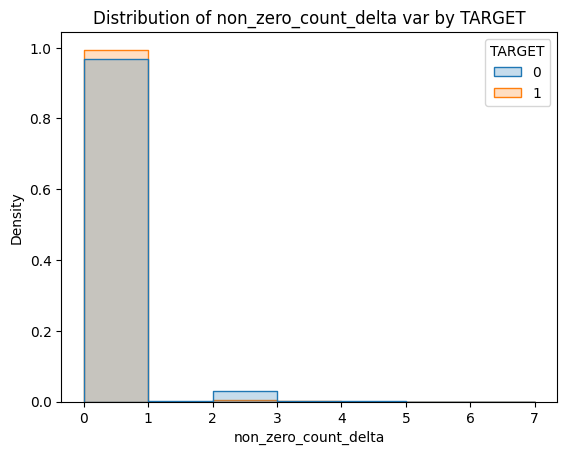

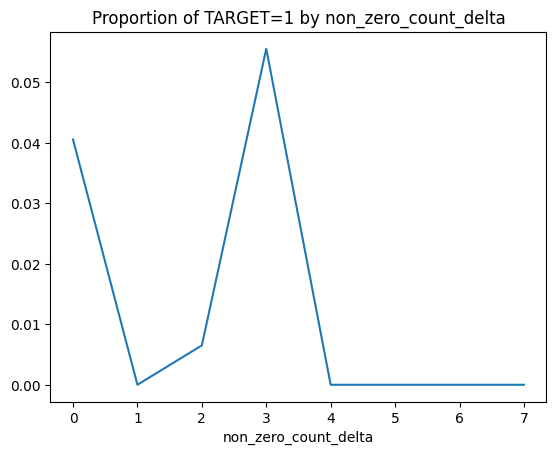

In [32]:
cv.binaryhistplot(df, "non_zero_count_delta", nbins=7)
cv.lineplot(df, "non_zero_count_delta")

##### Soma total das colunas

In [33]:
cs_delta = CustomSum(prefix="delta")
cs_delta = cs_delta.fit(df)
df = cs_delta.transform(df)

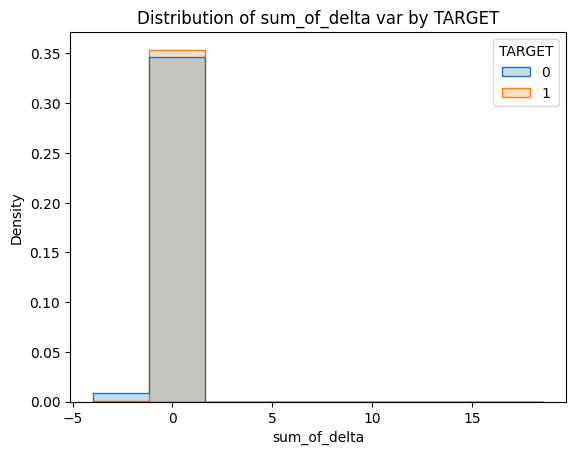

In [36]:
cv.binaryhistplot(df,"sum_of_delta", nbins=8)

In [37]:
df["TARGET"] \
    .value_counts(normalize=True) \
    .reset_index() \
        .merge(
            df \
                [df["sum_of_delta"]<0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_less_than_zero")
        ) \
        .merge(
            df \
                [df["sum_of_delta"]!=0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_not_zero")
        ) \
        .merge(
            df \
                [df["sum_of_delta"]>0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_greater_than_zero")
        )

,TARGET,proportion,proportion_less_than_zero,proportion_not_zero,proportion_greater_than_zero
0,0,0.960438,0.997137,0.997171,1.0
1,1,0.039562,0.002863,0.002829,NaN


### Ind

Prefixo "ind": estas variáveis são compostas exclusivamente por valores de 0 e 1, ou seja, são variáveis binárias.

Neste caso, como as variáveis já são binarizadas, a análise é mais simples. Não há nenhum outlier que chame a atenção ou levante suspeitas de serem, na verdade, missing features.

Foi criada a coluna de contagem de valores diferentes de zero. Desta vez, o plot de concentração de TARGET=1 por contagem de não-zeros é muito poluído, mostrando que esta variável não deve ter bom poder de discriminação.

In [53]:
ind_cols = [
    col
    for col in df.columns
    if col.startswith("ind")
]

df[ind_cols].describe().loc[["min", "max"]]

,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_cte,ind_var26,ind_var25,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32,ind_var33_0,ind_var33,ind_var34,ind_var37_cte,ind_var37,ind_var39_0,ind_var40_0,ind_var41_0,ind_var39,ind_var44_0,ind_var44,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [54]:
df[ind_cols] \
    .nunique() \
    .nlargest(10) \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,ind_var1_0,2
1,ind_var1,2
2,ind_var5_0,2
3,ind_var5,2
4,ind_var8_0,2
5,ind_var8,2
6,ind_var12_0,2
7,ind_var12,2
8,ind_var13_0,2
9,ind_var13_corto_0,2


In [55]:
anzc_ind = AddNonZeroCount(prefix="ind")
anzc_ind = anzc_ind.fit(df)
df = anzc_ind.transform(df)

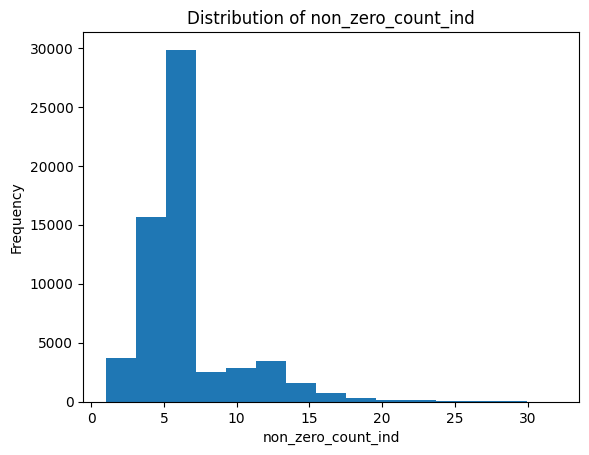

In [56]:
cv.histplot(df, "non_zero_count_ind", nbins=15)

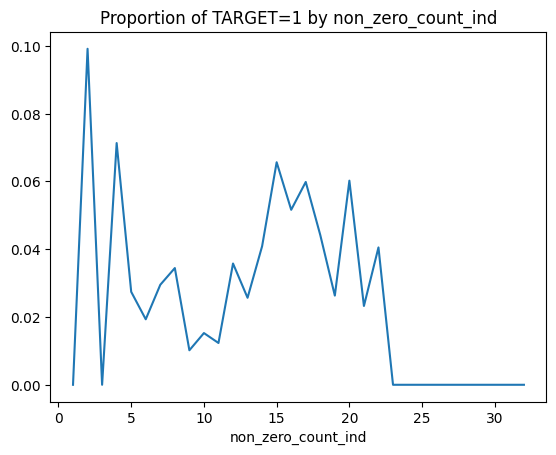

In [57]:
cv.lineplot(df, "non_zero_count_ind")

In [58]:
df[df["non_zero_count_ind"]>=24]["non_zero_count_ind"].count()

55

### Num

Prefixo "Num": o prefixo indica que as variáveis sejam uma contagem ("número de vendas", "número de recibos"). O fato de não haver nenhum valor negativo nem nenhum número decimal corrobora com esta ideia.

Assumiu-se que se tratam de variáveis de contagem e, para esta EDA, optou-se por não realizar qualquer alteração. Também não há um valor exorbitante comum entre as colunas, indicando que estes dados não tiveram valores faltantes preenchidos artificialmente.

Assim como no caso de "ind", a contagem de não-zeros não parece ser uma boa variável para discriminar a insatisfação, mas foi mantida mesmo assim, pois não sabemos se junto às demais variáveis ela pode ser útil. Por outro lado, a variável de soma mostra que, quanto maior seu valor, maior a probabilidade de insatisfação. O gráfico de violino, especialmente, mostra como a distribuição desta variável é diferente entre os dois grupos (TARGET=0 e TARGET=1)

#### Verificações generalizadas de "num"

In [59]:
num_cols = [
    col
    for col in df.columns
    if col.startswith("num")
]

df[num_cols].describe()

,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32,num_var33_0,num_var33,num_var34,num_var35,num_var37_med_ult2,num_var37,num_var39_0,num_var40_0,num_var41_0,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_reemb_var13_ult1,num_reemb_var17_hace3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_trasp_var17_in_hace3,num_trasp_var17_in_ult1,num_trasp_var17_out_ult1,num_trasp_var33_in_hace3,num_trasp_var33_in_ult1,num_trasp_var33_out_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3
count,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000
mean,0.033445,0.010754,1.080620,2.895570,1.999852,0.098856,0.085685,0.211770,0.138664,0.167719,0.129834,0.124260,0.037885,0.035764,0.160024,0.072563,0.016081,0.012727,0.009521,0.000049,0.010359,0.007449,0.128848,0.115134,0.089532,0.085635,0.020472,0.001135,0.054953,0.076559,1.618587,0.092443,2.875444,4.586474,1.639059,0.093577,2.930397,4.663033,0.000395,0.000099,3.374309,2.384323,0.020768,0.016476,0.003897,0.002269,0.001776,0.000099,3.302733,0.265341,0.420827,2.723954

In [60]:
df[num_cols] \
    .nunique() \
    .nlargest(10) \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,num_var45_ult3,160
1,num_op_var39_ult3,96
2,num_op_var41_ult3,93
3,num_op_var39_comer_ult3,89
4,num_var45_ult1,89
5,num_op_var41_comer_ult3,86
6,num_var45_hace2,80
7,num_op_var39_ult1,67
8,num_med_var45_ult3,66
9,num_op_var41_ult1,64


In [61]:
nfloat = df[num_cols].applymap(lambda x: 0 if x%1 == 0 else 1).sum().sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


#### Feature Engineering de "num"

##### Contagem de colunas diferentes de 0

In [62]:
anzc_num = AddNonZeroCount(prefix="num")
anzc_num = anzc_num.fit(df)
df = anzc_num.transform(df)

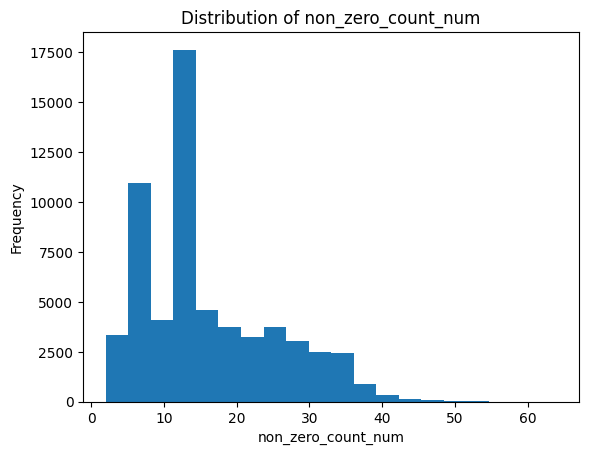

In [63]:
cv.histplot(df, "non_zero_count_num", nbins=20)

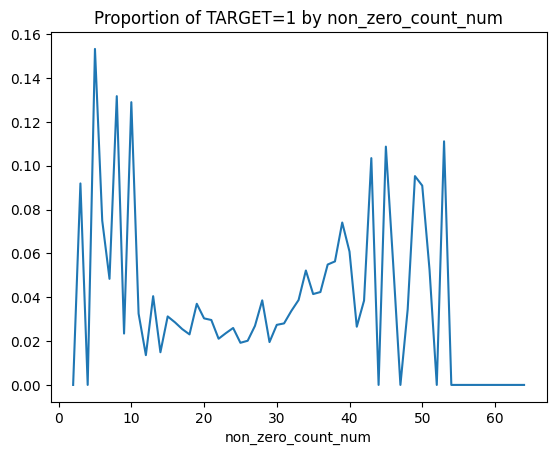

In [64]:
cv.lineplot(df, "non_zero_count_num")

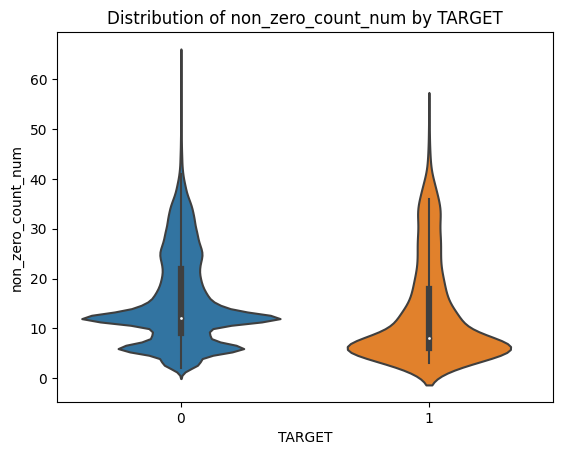

In [65]:
cv.violinplot(df, "non_zero_count_num")

##### Soma total das colunas

In [66]:
cs_num = CustomSum(prefix="num")
cs_num = cs_num.fit(df)
df = cs_num.transform(df)

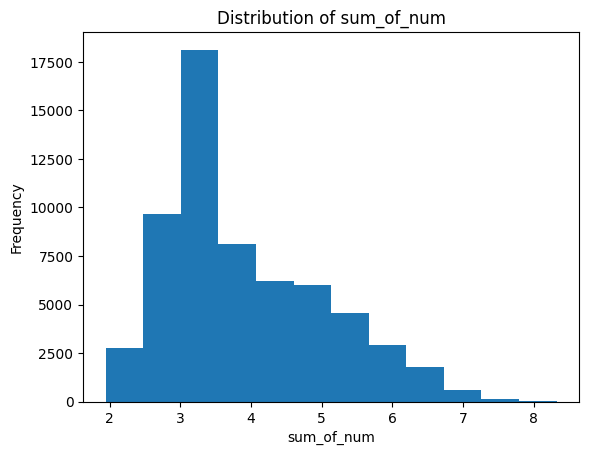

In [67]:
cv.histplot(
    df[["sum_of_num"]].applymap(lambda x: np.log(x+1)),
    "sum_of_num",
    nbins=12)

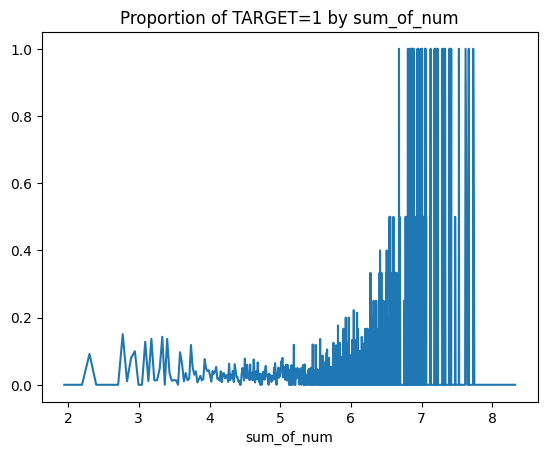

In [68]:
df_ = df.copy()
df_["sum_of_num"] = df_["sum_of_num"] \
    .apply(lambda x: np.log(x+1))

cv.lineplot(df_, "sum_of_num")

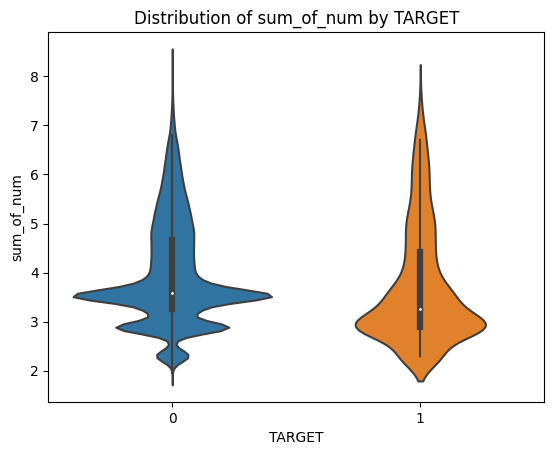

In [69]:
cv.violinplot(df_, "sum_of_num")

### Demais variáveis

Por fim, foram encontradas variáveis sem prefixos. Como são poucas variáveis, optou-se por tratá-las uma a uma, pois sem prefixo não podemos assumir que se tratam de grandezas semelhantes nem que são do mesmo tipo (contínua, discreta, categórica, etc).

O ideal seria abordar todas as variáveis desta forma e, inclusive, tentar relacionar variáveis de diferentes prefixos com base em seus nomes, pois aparentemente estas podem estar relacionadas (uma variável "ind" pode ser uma flag de uma variável "saldo", por exemplo).

#### Verificações generalizadas de demais variáveis

In [70]:
remaining_cols = [
    col
    for col in df.columns
    if (
        (col not in imp_cols)
        & (col not in ind_cols)
        & (col not in num_cols)
        & (col not in saldo_cols)
        & (col not in delta_cols)
        & ("count" not in col)
        & ("sum" not in col)
        & ("avg" not in col)
        & (col not in ["TARGET", "ID"])
    )
]

In [71]:
df[remaining_cols].describe()

,var3,var15,var36,var21,var38
count,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04
mean,-1526.496991,33.218742,40.507054,31.871547,1.176408e+05
std,39075.501176,12.947363,47.375790,393.703492,1.895319e+05
min,-999999.000000,5.000000,0.000000,0.000000,5.163750e+03
25%,2.000000,23.000000,2.000000,0.000000,6.777529e+04
50%,2.000000,28.000000,3.000000,0.000000,1.065147e+05
75%,2.000000,40.000000,99.000000,0.000000,1.187928e+05
max,238.000000,105.000000,99.000000,30000.000000,2.203474e+07


In [72]:
df[remaining_cols] \
    .nunique() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,var3,192
1,var15,100
2,var36,5
3,var21,22
4,var38,46671


#### var3

Esta variável possui 192 valores únicos, incluindo um único valor negativo de -999999 que se repete 93 vezes. Não há números decimais, apenas inteiros. Assume-se que é uma variável de contagem. Os valores de -999999 não foram tratados apesar de aparentarem nulos (assim como no caso das variáveis delta), pois a princípio usaremos modelos de árvore que, por sua vez, não são sensíveis à relação não linear entre as variáveis preditoras e a variável de interesse. Percebeu-se que em alguns casos onde esta variável é maior, há maior concentração de TARGET=1. Onde a variável é nula, TARGET=1 é menos frequente. 

In [73]:
var = "var3"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


In [74]:
df[df[var]<0][var].value_counts()

var3
-999999    93
Name: count, dtype: int64

In [75]:
df["TARGET"] \
    .value_counts(normalize=True) \
    .reset_index() \
        .merge(
            df \
                [df["var3"]<0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_less_than_zero")
        ) \
        .merge(
            df \
                [df["var3"]!=0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_not_zero")
        ) \
        .merge(
            df \
                [df["var3"]>0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_greater_than_zero")
        )

,TARGET,proportion,proportion_less_than_zero,proportion_not_zero,proportion_greater_than_zero
0,0,0.960438,0.978495,0.960478,0.96045
1,1,0.039562,0.021505,0.039522,0.03955


In [76]:
df[(df[var]<0) & (df[var] != -999999)][var].count()

0

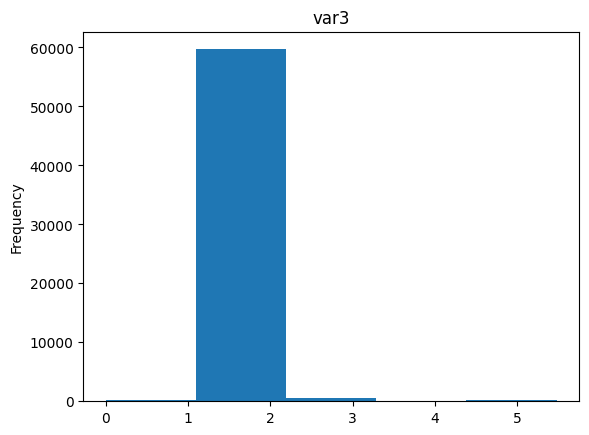

In [77]:
df_ = df.copy()
df_[var] = df_[var] \
    .apply(lambda x: None if x == -999999 else np.log(x+1))

df_[var]\
    .plot \
    .hist(bins=5)
plt.title(var)
plt.show()


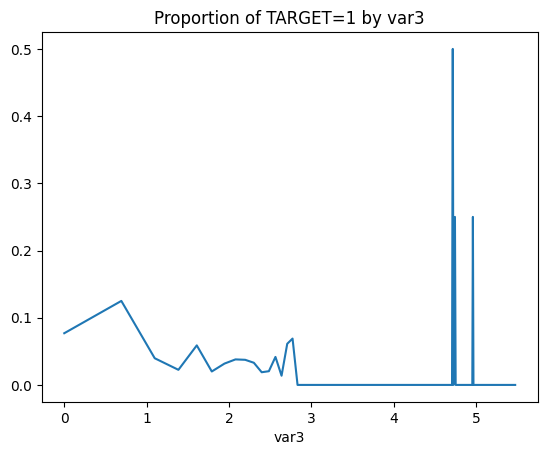

In [78]:
cv.lineplot(df_, var)

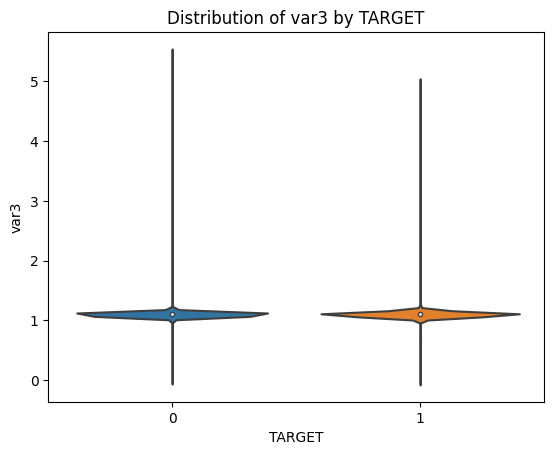

In [79]:
cv.violinplot(df_, var)

In [80]:
df_ = df.copy()
df_["null"] = df_[var].apply(lambda x: 1 if x == -999999 else 0)

df_ \
    .groupby("null")["TARGET"] \
    .value_counts(normalize=True) \
    .unstack()

TARGET,0,1
null,,
0,0.960410,0.039590
1,0.978495,0.021505


#### var15

Esta variável possui 100 valores únicos entre 5 e 105. Não há valores decimais. Todas estas características levam a acreditar que esta variável se trata da idade do cliente -- o que faz algum sentido, dada a escassez de clientes menores de 18 anos, que provavelmente é resultado de alguma política do banco. Assumiu-se que é uma variável numérica, sem necessidade de qualquer outro tratamento.

In [81]:
var = "var15"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


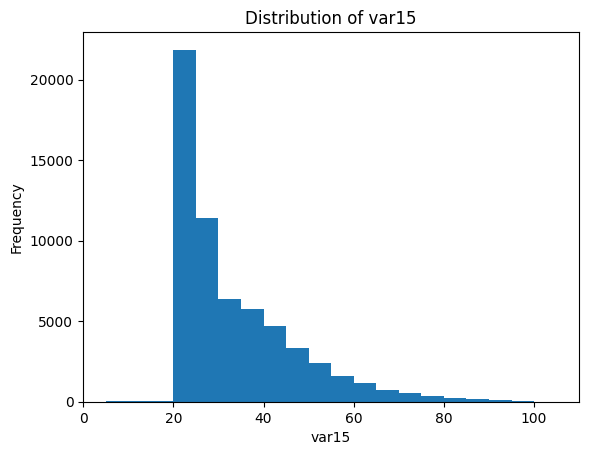

In [83]:
cv.histplot(df, var, nbins=20)

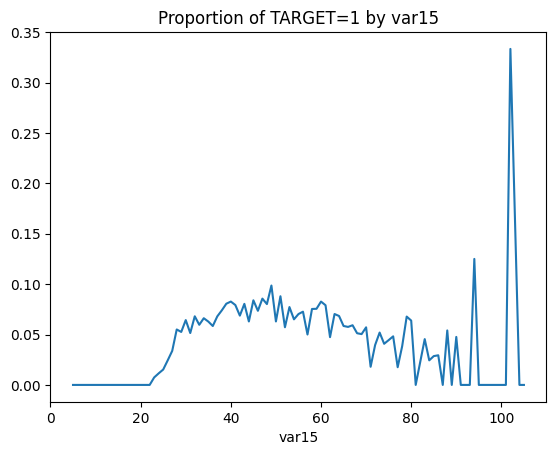

In [82]:
cv.lineplot(df, var)

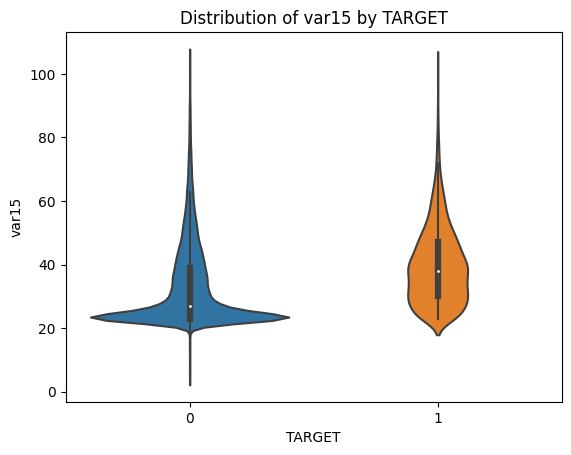

In [84]:
cv.violinplot(df, var)

#### var36

Esta variável aparenta ser uma variável categórica com labels não ordinais. Para os modelos de classificação baseados em árvore, será interessante aplicar um Ordinal Encoder para que as categorias sejam ordenadas com base na incidência de 1 na variável de interesse. Já para modelos lineares e análise de cluster, One Hot Encoding ou Weight of Evidence podem ser mais interessantes. O valor 99 aparenta ser artificial, mas será considerado como uma categoria por ser muito representativo.

In [85]:
var = "var36"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


In [86]:
df[var].value_counts()

var36
99    24088
3     17691
1     11728
2      6982
0       327
Name: count, dtype: int64

In [91]:
df \
    .groupby(var)["TARGET"] \
    .value_counts(normalize=True) \
    .unstack() \
    .sort_values(by=0, ascending=False)

TARGET,0,1
var36,,
0,1.000000,NaN
3,0.983607,0.016393
2,0.970066,0.029934
1,0.968366,0.031634
99,0.936234,0.063766


#### var21

Outra variável que aparenta ser categórica com labels não ordinais. O mesmo tratamento de var36 será aplicado nos modelos.

In [92]:
var = "var21"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


In [98]:
df_ = df \
    .groupby(var)["TARGET"] \
    .value_counts(normalize=True) \
    .unstack()

df_["count"] = df[var] \
    .value_counts()

df_.sort_values(by=0, ascending=False)

TARGET,0,1,count
var21,,,
30000,1.000000,NaN,1
6000,1.000000,NaN,21
1200,1.000000,NaN,8
1500,1.000000,NaN,24
18000,1.000000,NaN,2
10500,1.000000,NaN,1
2400,1.000000,NaN,3
2700,1.000000,NaN,23
9000,1.000000,NaN,10


#### var38
Já esta variável aparenta ser numérica, dada a grande quantidade de valores únicos e presença majoritária de números decimais.

In [99]:
var = "var38"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 60257


In [101]:
df[[var]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
var38,60816.0,117640.846586,189531.908253,5163.75,67775.2875,106514.73,118792.8225,22034738.76


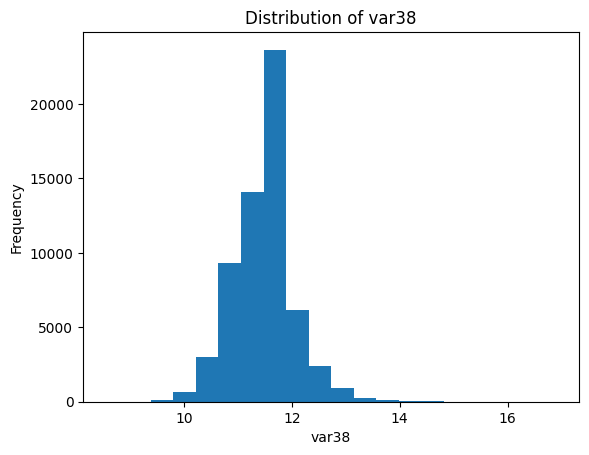

In [103]:
df_ = df.copy()
df_[var] = df_[var].apply(lambda x: np.log(x+1))

cv.histplot(df_, var, nbins=20)

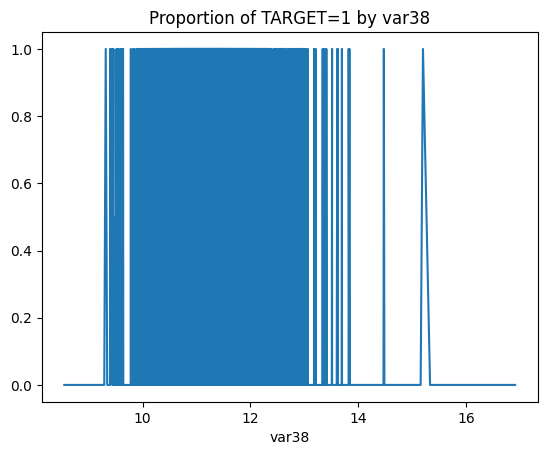

In [104]:
cv.lineplot(df_, var)

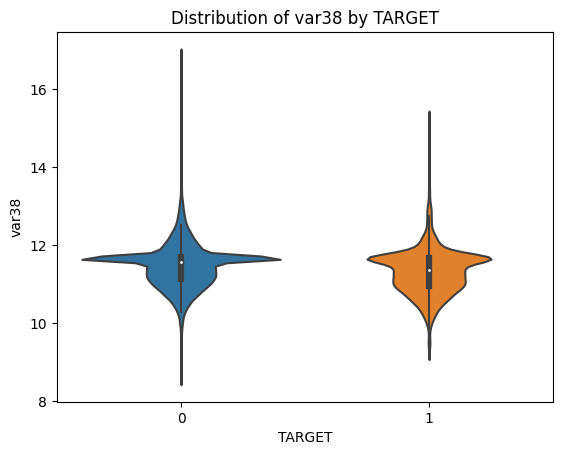

In [105]:
cv.violinplot(df_, var)